In [9]:
# needed libraries
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from torch import optim
from torchvision import datasets
from torchvision.transforms import transforms
from PIL import Image
import time
from torch.utils.data import Dataset
import time
from copy import deepcopy
import numpy as np
#////ResNet implementation by Aladdin Persson

#//// https://www.youtube.com/watch?v=DkNIBBBvcPs

In [10]:

class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1): #identity_downsample is the downsample of the identity block
        super(block, self).__init__() #inherit from nn.Module
        self.expansion = 4 #expansion is the expansion factor of the bottleneck
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)  #1x1 convolution
        self.bn1 = nn.BatchNorm2d(out_channels) #batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1) #3x3 convolution
        self.bn2 = nn.BatchNorm2d(out_channels) #batch normalization
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0) #1x1 convolution
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion) #batch normalization
        self.relu = nn.ReLU() #relu activation function
        self.identity_downsample = identity_downsample #identity downsample

    def forward(self, x): #forward pass
        identity = x #identity is the input

        x = self.conv1(x) #1x1 convolution
        x = self.bn1(x) #batch normalization
        x = self.relu(x) #relu activation function
        x = self.conv2(x) #3x3 convolution
        x = self.bn2(x) #batch normalization
        x = self.relu(x) #relu activation function
        x = self.conv3(x) #1x1 convolution
        x = self.bn3(x) #batch normalization

        if self.identity_downsample is not None: #if identity downsample is not None
            identity = self.identity_downsample(identity) #identity downsample

        x += identity #add identity to x
        x = self.relu(x) #relu activation function

        return x #return x (output of the block)


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): #block is the block class, layers is the number of layers, image_channels is the number of channels in the input image, num_classes is the number of classes in the output
        super(ResNet, self).__init__() #inherit from nn.Module

        self.in_channels = 64 #in_channels is the number of channels in the input image
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3) #7x7 convolution with stride 2 and padding 3
        self.bn1 = nn.BatchNorm2d(64) #batch normalization
        self.relu = nn.ReLU() #relu activation function
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #maxpool with kernel size 3, stride 2 and padding 1

        # resnet
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)  # 2048

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) #adaptive average pooling
        self.fc = nn.Linear(512 * 4, num_classes) #linear layer with 2048 output channels and num_classes input channels

    def forward(self, x):  #forward pass
        x = self.conv1(x) #7x7 convolution
        x = self.bn1(x) #batch normalization
        x = self.relu(x) #relu activation function
        x = self.maxpool(x) #maxpool with kernel size 3, stride 2 and padding 1

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x) #adaptive average pooling
        x = x.reshape(x.shape[0], -1) #reshape x to a vector
        x = self.fc(x) #linear layer with 2048 output channels and num_classes input channels

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride): #make layer function
        identity_downsample = None #identity_downsample is the identity downsample
        layers = [] #layers is a list of layers

        if stride != 1 or self.in_channels != out_channels * 4: #if stride is not 1 or the number of channels in the input image is not equal to the number of channels in the output image
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(out_channels * 4))
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride)) #append a block to layers with the input channels, output channels, identity downsample and stride
        self.in_channels = out_channels * 4 #in_channels is the number of channels in the input image

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) #append a block to layers with the input channels, output channels and identity downsample

        return nn.Sequential(*layers) #return a sequential layer with the layers in layers

num_classes = int(input("How many classes are in your dataset"))
image_channels = int(input("How many channels are in your image"))

def ResNet50(img_channels=image_channels, num_classes=num_classes):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)


def ResNet101(img_channels=image_channels, num_classes=num_classes):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)


def ResNet152(img_channels=image_channels, num_classes=num_classes):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)


def test():
    net = ResNet50()
    x = torch.rand(2, 3, 224, 224)
    y = net(x).to(('cuda' if torch.cuda.is_available() else 'cpu'))
    print(y.shape)


test()

torch.Size([2, 2])


In [11]:
base_dir = '/run/media/lorenz/SD 32GB L/Datasets' # Main Dataset which includes Train and Test folder
if os.path.exists(base_dir): # Generation of train and test path, if the train and test folders exist in the main dataset and are named 'Test' and 'Train'
    print('Found the data directory, now loading the data...')
    train_dir = os.path.join(base_dir, 'Train')
    test_dir = os.path.join(base_dir, 'Test')
    # prediction directory if available
   # predict_dir = os.path.join(base_dir, 'Prediction')
else:
    print('Could not find the data directory')
    exit()


Found the data directory, now loading the data...


In [12]:
# augmentation function for the data
train_dataset = datasets.ImageFolder(train_dir, transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(p=0.7),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
test_dataset = datasets.ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
# create predict dataset if available
"""
prediction_dataset = datasets.ImageFolder(predict_dir, transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(p=0.7),
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))
"""


for image, label in train_dataset:
    print(image.shape, label)
    break

# data loader for the data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
# prediction loader if available
"""
prediction_loader = torch.utils.data.DataLoader(prediction_dataset, batch_size=32, shuffle=False, num_workers=2)
"""
# summary of the data
dataset_sizes = {'Train': len(train_dataset), 'Test': len(test_dataset)}
print('Dataset sizes:', dataset_sizes)

torch.Size([3, 256, 256]) 0
Dataset sizes: {'Train': 8109, 'Test': 2262}


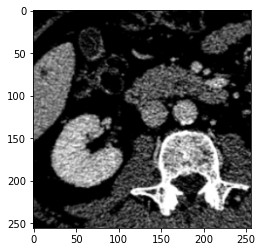

In [13]:
# showing an example image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(image)

In [14]:
# empty cuda cache to free up memory, if in use
torch.cuda.empty_cache()

In [15]:
# choose the ResNet model to use
net = input('Enter the network you want to use (50, 101, 152): ')
if net == '50':
    net = ResNet50()
elif net == '101':
    net = ResNet101()
elif net == '152':
    net = ResNet152()
else:
    print('Invalid network')
    exit()

# cuda if available
net = net.to(('cuda' if torch.cuda.is_available() else 'cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# train function
# shows the progress of the training
# after 1 epoch test on the test data
def train_model():
    epochs = int(input("Enter the number of epochs you want to train: "))
    train_sample_num = dataset_sizes['Train']
    test_sample_num = dataset_sizes['Test']
    train_cost, val_cost = [], []

    for epoch in range(epochs):
        start = time.time()  # start time for the epoch
        running_loss = 0.0  # reset the running loss
        for i, data in enumerate(train_loader, 0):  # iterate through the training data
            inputs, labels = data  # get the inputs and labels
            inputs, labels = inputs.to(('cuda' if torch.cuda.is_available() else 'cpu')), labels.to(
                ('cuda' if torch.cuda.is_available() else 'cpu'))  # move the inputs and labels to the GPU if available
            optimizer.zero_grad()  # reset the gradients
            outputs = net(inputs)  # get the outputs
            loss = criterion(outputs, labels)  # get the loss
            loss.backward()  # backpropagate the loss
            optimizer.step()  # update the weights
            running_loss += loss.item()  # add the loss to the running loss
            if i % 10 == 9:  # print every 10 batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))  # print the loss
                running_loss = 0.0  # reset the running loss
        end = time.time()  # end time for the epoch
        print('Epoch %d finished in %.2f seconds' % (epoch + 1, end - start))  # print the time taken for the epoch
        train_cost.append(running_loss / 10)  # add the loss to the train cost list
        with torch.no_grad():  # do not do backpropagation on the test data
            correct = 0  # reset the correct predictions
            total = 0  # reset the total predictions
            for data in test_loader:  # iterate through the test data
                images, labels = data  # get the inputs and labels
                images, labels = images.to(('cuda' if torch.cuda.is_available() else 'cpu')), labels.to((
                                                                                                            'cuda' if torch.cuda.is_available() else 'cpu'))  # move the inputs and labels to the GPU if available
                outputs = net(images)  # get the outputs
                _, predicted = torch.max(outputs.data, 1)  # get the predicted labels
                total += labels.size(0)  # add the batch size to the total
                correct += (predicted == labels).sum().item()  # add the correct predictions to the correct predictions
            val_cost.append(1 - correct / total)  # add the loss to the val cost list
            print(f'Accuracy of the network on the {len(test_dataset)} test images: %d %%' % (
                        100 * correct / total))  # print the accuracy of the network on the test data
    plt.plot(train_cost, label='Train')  # plot the train cost
    plt.plot(val_cost, label='Validation')  # plot the validation cost
    plt.legend()  # show the legend
    plt.show()  # show the plot
    torch.save(net.state_dict(), 'model.pth')  # save the model
    print('Model saved')  # print the model saved message
    return train_cost, val_cost


train_model()  # train the model

In [ ]:
# if prediction data is available, predict the images
"""
def prediction(prediction_data):
    with torch.no_grad():
        correct = 0
        total = 0
        for data in prediction_loader:
            images, labels = data
            images, labels = images.to(('cuda' if torch.cuda.is_available() else 'cpu')), labels.to(('cuda' if torch.cuda.is_available() else 'cpu'))
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Accuracy of the network on the {len(prediction_data)} test images: %d %%' % (100 * correct / total))
prediction(prediction_loader)
"""
